# Predict with future weather

In [1]:
from toolbox import *

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import pickle

In [2]:
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, SelectFromModel

from sklearn.model_selection import GridSearchCV

In [4]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

## Load data

In [5]:
#scenario_name = 'avg_t0_p0'
#scenario_name = 'avg_t+4_p+10'
#scenario_name = 'avg_t+2_p+05'
#scenario_name = 'avg_t+4_p-10'
scenario_name = 'avg_t-4_p+10'
#scenario_name = ''

#ws = load_weather_station_data('./data/weather_station_list.csv')
w = load_weather_data(f'./data/weather_future/{scenario_name}.csv')
#w = calc_cumulative_weather(w)

gs = load_groundwater_station_data('./data/groundwater/bergstraße/gw_stations_bergstraße.csv')
g = load_groundwater_data('./data/groundwater/bergstraße/gw.csv')

gs_agg = calc_aggregate_station_data(gs, g)
# setting more years improves model predictions
gs_agg = calc_initial_station_data(gs_agg, g, initial_n_years=5) 
gs_agg = gs_agg.drop('water_temp_mean', axis='columns')

In [6]:
#gs_agg[gs_agg.isna().any(axis=1)]
gs_agg = gs_agg.dropna()
gs_agg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 212 entries, 0 to 213
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   station_id                  212 non-null    int64          
 1   x                           212 non-null    float64        
 2   y                           212 non-null    float64        
 3   start_date                  212 non-null    datetime64[ns] 
 4   end_date                    212 non-null    datetime64[ns] 
 5   ground_elev                 212 non-null    float64        
 6   measure_elev                212 non-null    float64        
 7   lifespan                    212 non-null    timedelta64[ns]
 8   geometry                    212 non-null    geometry       
 9   water_level_mean            212 non-null    float64        
 10  water_depth_mean            212 non-null    float64        
 11  ini_years_water_depth_mean  212 non-null  

### Create regional clusters from gw stations

A good number of clusters is 10-12. Re-run if station data is changed.

In [7]:
#explore_clusters(gs_agg[['x', 'y']])

In [8]:
labels, centers = apply_clusters(gs_agg[['x', 'y']], 12, scale=False)

#plot_clusters(gs_agg[['x', 'y']], labels, centers)

# Add clusters to stations
gs_agg['reg_clusters'] = labels
#gs_agg['reg_clusters'] = 0

### Merge data

In [9]:
w['date'] = w.index
#w.info()

In [10]:
#w.describe()

In [11]:
df = gs_agg.merge(w, how='cross')

In [12]:
#df.info()

In [13]:
# restrict data to these columns
df = df[['station_id',
        'date',
        #'water_depth',
        'ground_elev',
        'x', 'y',
        'geometry',
        'reg_clusters',
        'ini_years_water_depth_mean',
        'ini_years_water_depth_std',
        'ini_years_water_depth_min',
        'ini_years_water_depth_max',
        'precip_mean',
        'tmean_mean',
        'moisture_mean',
        'precip_mean_prev_2d_sum',
        'precip_mean_prev_7d_sum',
        'precip_mean_prev_30d_sum',
        'precip_mean_prev_90d_sum',
        'precip_mean_prev_1y_sum',
        'precip_mean_prev_3y_sum',
        'tmean_mean_prev_2d_mean',
        'tmean_mean_prev_7d_mean',
        'tmean_mean_prev_30d_mean',
        'tmean_mean_prev_90d_mean',
        'tmean_mean_prev_1y_mean',
        'tmean_mean_prev_3y_mean'
       ]]
#df.info()

In [14]:
#df.describe()

### Prepare data

In [15]:
df[df.isna().any(axis=1)]

,station_id,date,ground_elev,x,y,geometry,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,...,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,precip_mean_prev_1y_sum,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean
0,12890,2000-01-03,87.44,458821.0,5505747.0,POINT (8.42892 49.70283),5,2.116130,0.590349,0.46,...,NaN,NaN,NaN,NaN,1.731736,NaN,NaN,NaN,NaN,NaN
1,12890,2000-01-10,87.44,458821.0,5505747.0,POINT (8.42892 49.70283),5,2.116130,0.590349,0.46,...,NaN,NaN,NaN,NaN,1.124987,1.224207,NaN,NaN,NaN,NaN
2,12890,2000-01-17,87.44,458821.0,5505747.0,POINT (8.42892 49.70283),5,2.116130,0.590349,0.46,...,NaN,NaN,NaN,NaN,0.628359,0.838034,NaN,NaN,NaN,NaN
3,12890,2000-01-24,87.44,458821.0,5505747.0,POINT (8.42892 49.70283),5,2.116130,0.590349,0.46,...,NaN,NaN,NaN,NaN,3.011544,2.104883,NaN,NaN,NaN,NaN
4,12890,2000-01-31,87.44,458821.0,5505747.0,POINT (8.42892 49.70283),5,2.116130,0.590349,0.46,...,51.692451,NaN,NaN,NaN,1.260382,1.787158,1.504782,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550650,17131,2002-11-25,97.56,469267.0,5491023.0,POINT (8.57494 49.57102),11,3.803333,0.119304,3.72,...,61.995505,176.470611,689.891359,NaN,3.110380,3.453641,5.408443,10.414639,10.055507,NaN
550651,17131,2002-12-02,97.56,469267.0,5491023.0,POINT (8.57494 49.57102),11,3.803333,0.119304,3.72,...,61.015153,180.799562,692.399550,NaN,2.225510,3.000155,4.428151,9.377689,10.061366,NaN
550652,17131,2002-12-09,97.56,469267.0,5491023.0,POINT (8.57494 49.57102),11,3.803333,0.119304,3.72,...,65.796295,176.389571,696.298508,NaN,3.356721,3.129952,3.750252,8.412365,10.060786,NaN
550653,17131,2002-12-16,97.56,469267.0,5491023.0,POINT (8.57494 49.57102),11,3.803333,0.119304,3.72,...,64.990998,178.029622,698.283716,NaN,1.054857,2.644412,3.174685,7.459066,10.058361,NaN


In [16]:
df = df.dropna()
#df

In [17]:
reserve_cols_as_info = ['station_id', 'date', 'geometry']
    
info = df[reserve_cols_as_info].copy()

X = df.copy().drop(reserve_cols_as_info, axis=1)

## Unpickle model

In [18]:
# load model
if True:
    name = 'HGBoost'
    
    with open(f'./models/{name}.pkl', 'rb') as file:
        model = pickle.load(file)
    
    model#.best_params_

## Predict groundwater levels

In [19]:
y_pred = pd.DataFrame(model.predict(X), columns=['pred_water_depth'])
y_pred.index = info.index
#y_pred.head()

In [20]:
#X.head()

In [21]:
#info.head()

In [22]:
pred = pd.concat([info, X, y_pred], axis='columns')
pred.head()

,station_id,date,geometry,ground_elev,x,y,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,...,precip_mean_prev_90d_sum,precip_mean_prev_1y_sum,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean,pred_water_depth
156,12890,2002-12-30,POINT (8.42892 49.70283),87.44,458821.0,5505747.0,5,2.11613,0.590349,0.46,...,193.069946,701.204728,2099.986596,0.937394,2.178536,2.483007,5.618858,10.048706,10.089270,1.745632
157,12890,2003-01-06,POINT (8.42892 49.70283),87.44,458821.0,5505747.0,5,2.11613,0.590349,0.46,...,197.961828,702.307557,2100.337240,1.220114,1.172203,2.101613,4.800816,10.041723,10.087307,1.750262
158,12890,2003-01-13,POINT (8.42892 49.70283),87.44,458821.0,5505747.0,5,2.11613,0.590349,0.46,...,194.980985,702.094152,2102.235229,0.230585,0.996740,1.563699,4.045384,10.034287,10.088758,1.744024
159,12890,2003-01-20,POINT (8.42892 49.70283),87.44,458821.0,5505747.0,5,2.11613,0.590349,0.46,...,190.259305,699.348872,2100.312207,1.247891,0.831694,1.346013,3.426472,10.030130,10.085665,1.674637
160,12890,2003-01-27,POINT (8.42892 49.70283),87.44,458821.0,5505747.0,5,2.11613,0.590349,0.46,...,190.345709,700.252991,2101.510285,2.191666,2.237202,1.284656,2.959493,10.034866,10.085341,1.625946


In [23]:
if True:
    pred.to_feather(f'./data/predictions/{scenario_name}.feather')

## Analyse prediction

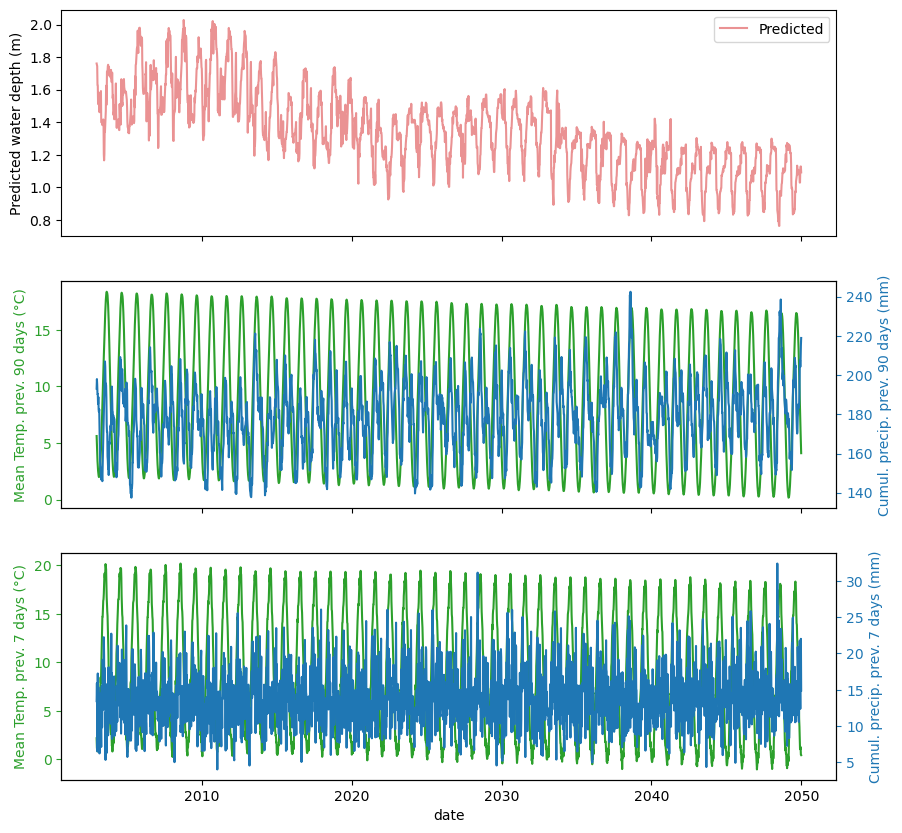

In [24]:
data = pred.loc[pred.station_id == pred.station_id.unique()[12]]

plot_predicted_data(data,
                  #pd.to_datetime('2035-01-01'), pd.to_datetime('2045-01-10'),
                  #pd.to_datetime('2040-01-01'), pd.to_datetime('2044-01-10')
                  #save=True
                 )

#plt.savefig('./figs/test.png', bbox_inches='tight')